# Bone Age Assessment from Hand-Wrist Radiographs: Neural Network Approaches

Daniela Di Labbio, Erica Marras

📁 Data set available here: https://drive.google.com/drive/folders/1-A5lB-_YRT294gPYqM1pTo8uvkwqkMjO

In [1]:
import zipfile
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2
import glob
import time
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Embedding
from tensorflow.keras.models import Model
import matplotlib.patches as patches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
cd '/content/drive/MyDrive/HDA_project'

/content/drive/MyDrive/HDA_project


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading Images, Preprocesssing Steps, Augmentation

In [5]:
# Data
RSNA_gtd = pd.read_csv("./BoneAge_dataset/train.csv")
RSNA_folder = './BoneAge_dataset/boneage-training-dataset'

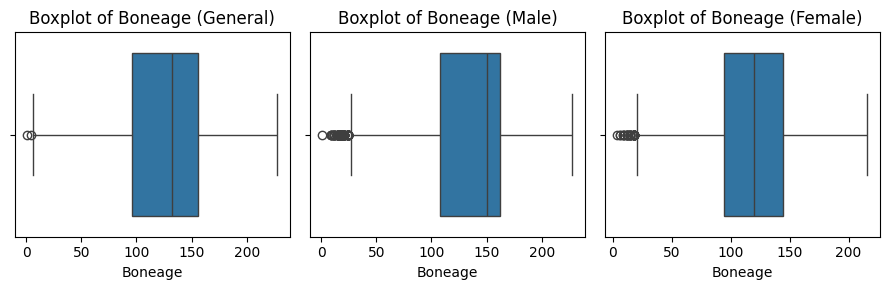

Statistics for Boneage:
count    12611.000000
mean       127.320752
std         41.182021
min          1.000000
25%         96.000000
50%        132.000000
75%        156.000000
max        228.000000
Name: boneage, dtype: float64

Statistics for Boneage by Gender:
         count        mean        std  min    25%    50%    75%    max
gender                                                                
Female  5778.0  117.880235  37.908112  4.0   94.0  120.0  144.0  216.0
Male    6833.0  135.303673  42.143162  1.0  108.0  150.0  162.0  228.0


In [6]:
RSNA_gtd['gender'] = RSNA_gtd['male'].apply(lambda x: 'Male' if x else 'Female')

plt.figure(figsize=(9, 3))

# General Boxplot (all data)
plt.subplot(1, 3, 1)
sns.boxplot(x=RSNA_gtd['boneage'])
plt.title('Boxplot of Boneage (General)')
plt.xlabel('Boneage')

# Boxplot for Male
plt.subplot(1, 3, 2)
sns.boxplot(x='boneage', data=RSNA_gtd[RSNA_gtd['male'] == True])
plt.title('Boxplot of Boneage (Male)')
plt.xlabel('Boneage')

# Boxplot for Female
plt.subplot(1, 3, 3)
sns.boxplot(x='boneage', data=RSNA_gtd[RSNA_gtd['male'] == False])
plt.title('Boxplot of Boneage (Female)')
plt.xlabel('Boneage')


plt.tight_layout()
plt.show()

# Print statistics
print("Statistics for Boneage:")
print(RSNA_gtd['boneage'].describe())

print("\nStatistics for Boneage by Gender:")
print(RSNA_gtd.groupby('gender')['boneage'].describe())

In [7]:
'''SMALL DATA SET TO TEST MODEL VARIATIONS/IDEAS'''
# train_size = 1504
# validation_size = 188
# test_size = 188

'''ENTIRE DATA SET:'''
train_size = 10089
validation_size = 1261
test_size = 1261

# List all the images in the directory
train_image_paths = [os.path.join(RSNA_folder, fname) for fname in os.listdir(RSNA_folder)[:train_size] if fname.endswith('.png')]
validation_image_paths = [os.path.join(RSNA_folder, fname) for fname in os.listdir(RSNA_folder)[train_size:train_size+validation_size] if fname.endswith('.png')]
test_image_paths = [os.path.join(RSNA_folder, fname) for fname in os.listdir(RSNA_folder)[train_size+validation_size:train_size+validation_size+test_size] if fname.endswith('.png')]

train_dataset = tf.data.Dataset.from_tensor_slices(train_image_paths)
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_image_paths)
test_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)

print("train:", len(train_dataset))
print("")
print("validation:", len(validation_dataset))
print("")
print("test:",len(test_dataset))

train: 10089

validation: 1261

test: 1261


In [8]:
# Create a mapping including age and gender
train_info_dict = {row['id']: (row['boneage'], row['male']) for _, row in RSNA_gtd.iterrows()}

In [9]:
# normalization to [0,255]
def normalize_image(image):
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    normalized_image = (image - min_val) / (max_val - min_val) * 255.0
    return tf.cast(normalized_image, tf.uint8)

# random zoom
def random_zoom(image, zoom_range=(0.8, 1.2)):
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])
    new_size = tf.cast(tf.shape(image)[0:2], tf.float32) * zoom_factor
    new_size = tf.cast(new_size, tf.int32)
    image = tf.image.resize(image, new_size)
    return tf.image.resize_with_crop_or_pad(image, 256, 256)

# CLAHE
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    image_np = image.numpy()

    # Check if the image is grayscale (1 channel)
    if image_np.ndim == 3 and image_np.shape[2] == 1:
        image_bw = image_np.squeeze()
    elif image_np.ndim == 3 and image_np.shape[2] == 3:
        image_bw = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Image must be either grayscale (1 channel) or RGB (3 channels)")

    # Ensure image_bw is of type uint8
    if image_bw.dtype != np.uint8:
        image_bw = (image_bw * 255).astype(np.uint8)

    # Calculate brightness for dynamic clip limit
    brightness = np.mean(image_bw)

    # Set clip limit based on brightness
    if brightness < 85:
        clip_limit = 5.0
    elif 85 <= brightness < 170:
        clip_limit = 3.0
    else:
        clip_limit = 2.0

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    final_img_clahe = clahe.apply(image_bw)

    return (tf.convert_to_tensor(image_bw, dtype=tf.float32) / 255.0,
            tf.convert_to_tensor(final_img_clahe, dtype=tf.float32) / 255.0)

# random rotation
random_rotation_layer = tf.keras.layers.RandomRotation(0.125)  # 0.125 radians ~ 7.2 degrees

# Load, Preprocessing and Augmentation
def load_image(path, info_dict, augmentation=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [256, 256])

    image = normalize_image(image)

    image_bw, image = tf.py_function(apply_clahe, [image], [tf.float32, tf.float32])
    image.set_shape([256, 256])
    image = tf.expand_dims(image, axis=-1)

    if augmentation:
        image = tf.image.random_flip_left_right(image)
        image = random_rotation_layer(image)
        image = tf.image.random_brightness(image, 0.1)
        image = random_zoom(image)

    image = tf.image.resize(image, [224, 224])

    img_id = tf.strings.split(path, os.sep)[-1]
    img_id = tf.strings.split(img_id, '.')[0]

    def get_info(img_id):
        img_id_int = int(img_id.numpy().decode('utf-8'))  # Convert to integer
        return info_dict.get(img_id_int)

    age, gender = tf.py_function(get_info, [img_id], [tf.float32, tf.bool])

    # Set the shapes of the outputs
    age.set_shape([])  # Scalar
    gender.set_shape([])  # Scalar

    return image, age, gender


In [10]:
train_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths), seed=42).take(train_size)
validation_dataset = validation_dataset.shuffle(buffer_size=len(validation_image_paths), seed=42).take(validation_size)
test_dataset = test_dataset.take(test_size)


train_data = train_dataset.map(lambda x: load_image(x, train_info_dict, augmentation=True))
val_data = validation_dataset.map(lambda x: load_image(x, train_info_dict))
test_data = test_dataset.map(lambda x: load_image(x, train_info_dict))

batch_size = 16

train_data = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Visualize

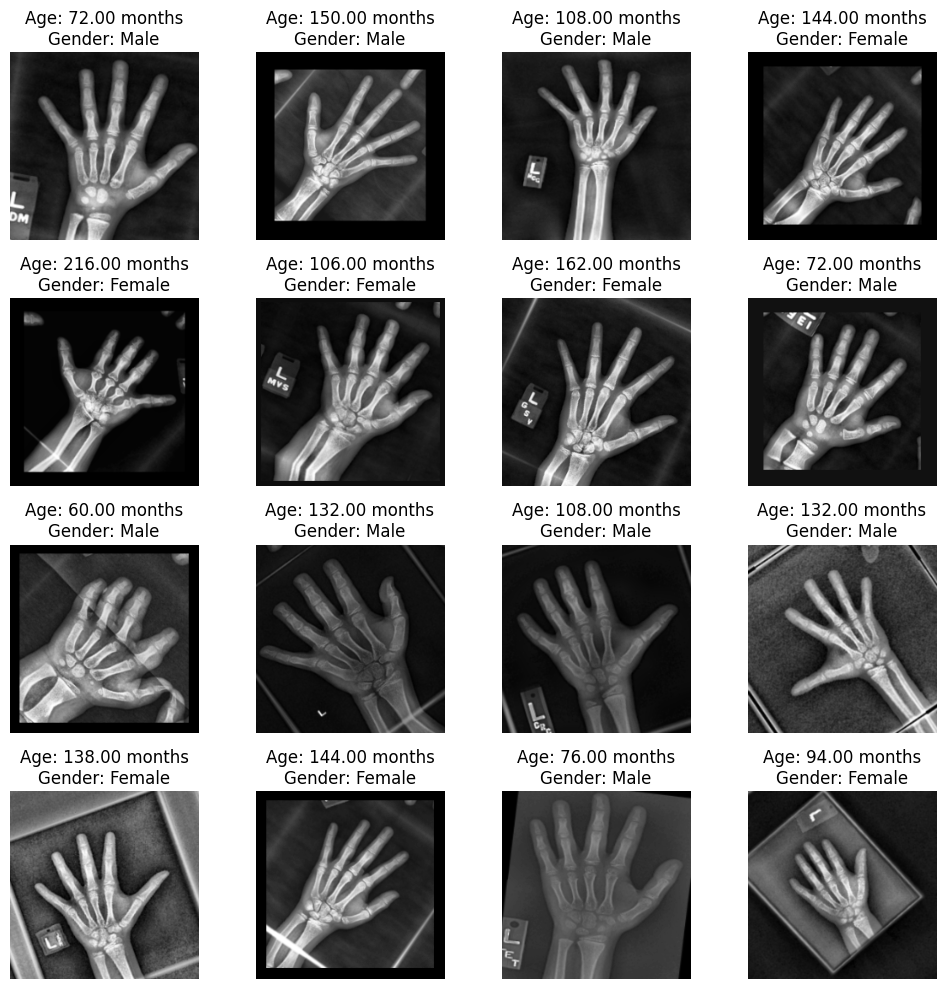

In [ ]:
'''EXAMPLE IMAGES CONTAINED IN A BATCH'''

def visualize_example(dataset, batch=1):
    for image, age, gender in dataset.take(batch):
        plt.figure(figsize=(10, 10))
        for i in range(16):
            if i >= len(image):
                break
            image_i = image.numpy()[i]
            age_i = age.numpy()[i]
            gender_i = gender.numpy()[i]

            ax = plt.subplot(4, 4, i + 1)
            ax.imshow(image_i, cmap="gray")
            ax.set_title(f'Age: {age_i:.2f} months\nGender: {"Male" if gender_i else "Female"}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

# Visualize
visualize_example(train_data, 1)

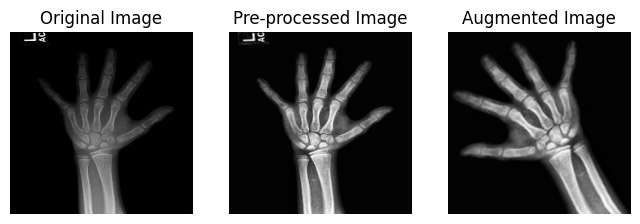

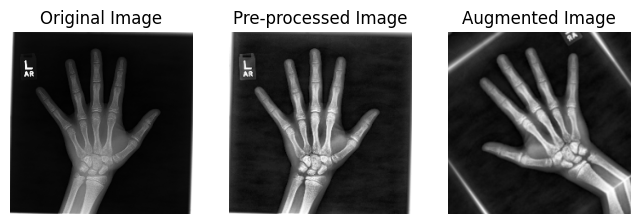

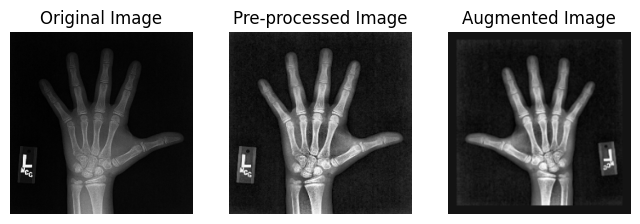

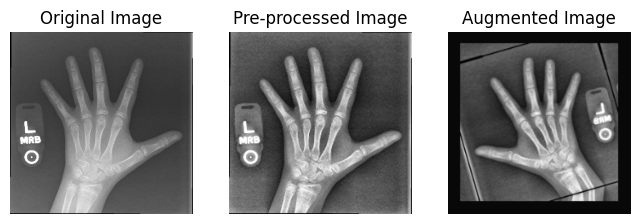

In [ ]:
'''VISUALIZE SOME EXAMPLE OF ORIGINAL IMAGES, PREPROCESSED IMAGES, IMAGES WITH AUGMENTATION'''

def visualize_multiple_images_clahe_comparison(image_paths, info_dict, num_images=2):
    for i in range(num_images):
        image_path = image_paths[i]

        image_original = tf.io.read_file(image_path)
        image_original = tf.image.decode_png(image_original, channels=1)
        image_original = tf.image.resize(image_original, [256, 256])
        image_original = normalize_image(image_original)

        # apply load_image to preprocess
        image_clahe, age, gender = load_image(image_path, info_dict, augmentation=False)
        image_augmented, age_augmented, gender_augmented = load_image(image_path, info_dict, augmentation=True)

        image_clahe_np = image_clahe.numpy()
        image_augmented_np = image_augmented.numpy()
        image_original_np = image_original.numpy()

        gender_label = "Male" if gender else "Female"
        gender_label_augmented = "Male" if gender_augmented else "Female"

        plt.figure(figsize=(8, 8))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(image_original_np, cmap="gray")
        # plt.title(f'Original Image\nAge: {age.numpy()} months\nGender: {gender_label}')
        plt.title(f'Original Image')
        plt.axis('off')

        # Preprocessed Image (with CLAHE)
        plt.subplot(1, 3, 2)
        plt.imshow(image_clahe_np, cmap="gray")
        plt.title(f'Pre-processed Image')
        plt.axis('off')

        # Augmented Image
        plt.subplot(1, 3, 3)
        plt.imshow(image_augmented_np, cmap="gray")
        plt.title(f"Augmented Image")
        plt.axis("off")

        plt.show()

visualize_multiple_images_clahe_comparison(train_image_paths, train_info_dict, num_images=4)

## Auxilary functions

In [11]:
def load_saved_weights(model, weights_folder, path):
  weights_path = os.path.join(weights_folder, path)
  model.load_weights(weights_path)

In [12]:
def config_model(architecture, model_name, model_variant, input_shape=(224, 224, 1)):

    if model_variant == 'base':
        gender_shape = None
        weights_folder = f'./{model_name}_weights'

    elif model_variant == 'gender1':
        gender_shape = (2,)
        weights_folder = f'./{model_name}_one_hot_gender_weights'


    elif model_variant == 'gender2':
        gender_shape = 1
        weights_folder = f'./{model_name}_gender_embedding_weights'

    else:
      print("Invalid model_variant.")

    model = architecture(input_shape, gender_shape)
    model.summary()
    print("")
    return model, weights_folder

In [13]:
def normalize_labels(labels):
    return labels / 228.0

def denormalize_predictions(predictions):
    return predictions * 228.0

In [14]:
def compute_attention_mask_get_bounding_boxes(feature_maps, tau=0.7):
    is_batch = len(feature_maps.shape) == 4  # for batch handling
    scale_factor = 2  # feature_maps is (112,112) while image is (224,224)

    def process_single_image(single_feature_map):
        # single_feature_map = tf.abs(single_feature_map) ## RELU function, so abs not necessary
        attention_heatmap = tf.reduce_max(single_feature_map, axis=-1)

        # Normalize the attention heatmap
        min_val = tf.reduce_min(attention_heatmap)
        max_val = tf.reduce_max(attention_heatmap)
        normalized_heatmap = tf.where(max_val > min_val, (attention_heatmap - min_val) / (max_val - min_val), tf.zeros_like(attention_heatmap))

        # Create binary mask with threshold
        binary_mask = tf.where(normalized_heatmap > tau, 1, 0)
        binary_mask = tf.cast(binary_mask, tf.uint8)

        # Convert TensorFlow tensor to NumPy for OpenCV connected component analysis
        binary_mask_np = binary_mask.numpy()
        num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(binary_mask_np)

        if num_labels > 1:
            max_label = 1 + tf.argmax(stats[1:, cv2.CC_STAT_AREA]).numpy()  # Skip the background label
            x_min, y_min, width, height = stats[max_label, :4]
            x_max, y_max = x_min + width, y_min + height
        else:
            x_min, y_min, x_max, y_max = 0, 0, binary_mask.shape[0], binary_mask.shape[1]

        # Adjust bounding box to be square
        box_width = x_max - x_min
        box_height = y_max - y_min
        max_side = max(box_width, box_height)

        if box_width < max_side:
            pad = (max_side - box_width) // 2
            x_min, x_max = max(0, x_min - pad), min(223, x_max + pad)
        if box_height < max_side:
            pad = (max_side - box_height) // 2
            y_min, y_max = max(0, y_min - pad), min(223, y_max + pad)

        # Scale and clamp bounding box coordinates
        x_min, x_max = max(0, int(x_min * scale_factor)), min(223, int(x_max * scale_factor))
        y_min, y_max = max(0, int(y_min * scale_factor)), min(223, int(y_max * scale_factor))

        return (x_min, y_min, x_max, y_max)

    if is_batch:
        bounding_boxes = [process_single_image(feature_maps[i]) for i in range(feature_maps.shape[0])]
    else:
        bounding_boxes = [process_single_image(feature_maps)]

    return bounding_boxes

In [15]:
def extract_local_region(global_images, feature_maps, target_size=(224, 224), tau=0.7):
    bounding_boxes = compute_attention_mask_get_bounding_boxes(feature_maps, tau=tau)

    local_crops = []
    for i, (global_image, (x_min, y_min, x_max, y_max)) in enumerate(zip(global_images, bounding_boxes)):
        # Ensure cropping boundaries are within image dimensions
        height, width = global_image.shape[:2]
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(width, x_max), min(height, y_max)

        # Calculate crop height and width
        crop_height = y_max - y_min
        crop_width = x_max - x_min

        # Use crop_to_bounding_box to extract the local region
        try:
            local_crop = tf.image.crop_to_bounding_box(global_image, y_min, x_min, crop_height, crop_width)
        except tf.errors.InvalidArgumentError:
            print(f"Warning: Invalid bounding box for image {i+1}. Returning original image.")
            local_crop = global_image  # Return the original image if the crop is invalid

        # Resize or pad to the target size
        local_crop_resized = tf.image.resize_with_crop_or_pad(local_crop, target_size[0], target_size[1])
        local_crops.append(local_crop_resized)

    return tf.stack(local_crops, axis=0)  # Stack along the batch dimension


In [16]:
def visualize_features(original_image, feature_map, local_crop, bounding_box, epoch, i):
    original_image = tf.squeeze(original_image)
    feature_map_rescaled = tf.reduce_max(feature_map, axis=-1)  # Reduce to single channel for visualization
    local_crop_squeezed = tf.squeeze(local_crop)  # Removes dimensions of size 1

    if local_crop_squeezed.ndim == 2:  # If it is 2D (H, W)
      local_crop_squeezed = tf.expand_dims(local_crop_squeezed, axis=-1)  # Convert to (H, W, 1)

    # Get bounding box coordinates
    x_min, y_min, x_max, y_max = bounding_box

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Epoch {epoch + 1}")

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')

    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor='blue', facecolor='none')
    plt.gca().add_patch(rect)

    # Feature Map with Bounding Box
    plt.subplot(1, 3, 2)
    plt.title("Feature Map")
    plt.imshow(feature_map_rescaled, cmap='coolwarm')

    scale_factor = 2 #since the feature maps is (112,112)
    x_min = int(x_min / scale_factor)
    y_min = int(y_min / scale_factor)
    x_max = int(x_max / scale_factor)
    y_max = int(y_max / scale_factor)

    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor='blue', facecolor='none')
    plt.gca().add_patch(rect)

    plt.subplot(1, 3, 3)
    plt.title("Cropped Image (Local Branch)")
    plt.imshow(local_crop_squeezed, cmap="gray")

    plt.show()

## TRAIN function

In [17]:
def train_models(model, gender_input_shape, train_data, val_data, weights_folder, num_epochs=60, initial_learning_rate=0.001, tau=0.3, patience=3):
    optimizer = tf.keras.optimizers.Adam(initial_learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()
    os.makedirs(weights_folder, exist_ok=True)
    best_val_loss = float('inf')
    patience_counter = 0

    lr_scheduler = initial_learning_rate

    if "GlobalLocal" in weights_folder:
      # Sub-model to extract feature map after the global branch in the Global-Local ResNet
      feature_extractor = tf.keras.Model(
          inputs=model.inputs,
          outputs=model.get_layer("res_block_128_2_relu2").output)

    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0
        print("")
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        with tqdm(total=len(train_data), desc="Training", unit="batch") as pbar:
            for batch_index, (batch_images, batch_labels, batch_genders) in enumerate(train_data):
                batch_labels = normalize_labels(batch_labels)

                '''simple'''
                if gender_input_shape is None:
                  if "GlobalLocal" in weights_folder:
                    # Visualize the first three images in the first batch
                    if batch_index == 0:
                        feature_maps_batch = feature_extractor([batch_images], training=False)
                        for i in range(3):  # First three images only
                            original_image = batch_images[i]
                            feature_map = feature_maps_batch[i]
                            bounding_boxes = compute_attention_mask_get_bounding_boxes(feature_map, tau)
                            cropped_image = tf.image.crop_to_bounding_box(original_image, bounding_boxes[0][1], bounding_boxes[0][0], bounding_boxes[0][3] - bounding_boxes[0][1], bounding_boxes[0][2] - bounding_boxes[0][0])
                            # Resize the cropped image
                            cropped_image = tf.image.resize(cropped_image, (224, 224))

                            visualize_features(original_image, feature_map, cropped_image, bounding_boxes[0], epoch, i)

                  with tf.GradientTape() as tape:
                      predictions = model(batch_images, training=True)
                      loss = loss_fn(batch_labels, predictions)

                '''one-hot encodign of gender'''
                if gender_input_shape == (2,):
                  batch_genders_int = tf.cast(batch_genders, dtype=tf.int32)
                  batch_genders_one_hot = tf.one_hot(batch_genders_int, depth=2)

                  if "GlobalLocal" in weights_folder:
                    # Visualize the first three images in the first batch
                    if batch_index == 0:
                        feature_maps_batch = feature_extractor([batch_images, batch_genders_one_hot], training=False)
                        for i in range(3):  # First three images only
                            original_image = batch_images[i]
                            feature_map = feature_maps_batch[i]
                            bounding_boxes = compute_attention_mask_get_bounding_boxes(feature_map, tau)
                            cropped_image = tf.image.crop_to_bounding_box(original_image, bounding_boxes[0][1], bounding_boxes[0][0], bounding_boxes[0][3] - bounding_boxes[0][1], bounding_boxes[0][2] - bounding_boxes[0][0])
                            # Resize the cropped image
                            cropped_image = tf.image.resize(cropped_image, (224, 224))

                            visualize_features(original_image, feature_map, cropped_image, bounding_boxes[0], epoch, i)

                  with tf.GradientTape() as tape:
                      predictions = model([batch_images, batch_genders_one_hot], training=True)
                      loss = loss_fn(batch_labels, predictions)

                '''gender embedding'''
                if gender_input_shape == 1:
                  batch_genders_int = tf.cast(batch_genders, dtype=tf.int32)

                  if "GlobalLocal" in weights_folder:
                    # Visualize the first three images in the first batch
                    if batch_index == 0:
                        feature_maps_batch = feature_extractor([batch_images, batch_genders_int], training=False)
                        for i in range(3):  # First three images only
                            original_image = batch_images[i]
                            feature_map = feature_maps_batch[i]
                            bounding_boxes = compute_attention_mask_get_bounding_boxes(feature_map, tau)
                            cropped_image = tf.image.crop_to_bounding_box(original_image, bounding_boxes[0][1], bounding_boxes[0][0], bounding_boxes[0][3] - bounding_boxes[0][1], bounding_boxes[0][2] - bounding_boxes[0][0])
                            # Resize the cropped image
                            cropped_image = tf.image.resize(cropped_image, (224, 224))

                            visualize_features(original_image, feature_map, cropped_image, bounding_boxes[0], epoch, i)

                  with tf.GradientTape() as tape:
                      predictions = model([batch_images, batch_genders_int], training=True)
                      loss = loss_fn(batch_labels, predictions)


                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                epoch_loss += loss.numpy()
                num_batches += 1
                pbar.set_postfix({"loss": loss.numpy()})
                pbar.update(1)

        avg_epoch_loss = epoch_loss / num_batches
        print(f"Avg Training Loss: {avg_epoch_loss}")

        # Save best model
        weights_path = os.path.join(weights_folder, f"{model.name}_epoch_{epoch + 1}_lr_{lr_scheduler}.weights.h5")
        model.save_weights(weights_path)
        print(f"- - - - - - - - - - - Weights saved at: {weights_path}")

        if val_data is not None:
            val_loss = 0
            val_batches = 0
            with tqdm(total=len(val_data), desc="Validating", unit="batch") as pbar:
                for val_images, val_labels, val_genders in val_data:
                    val_labels = normalize_labels(val_labels)
                    if gender_input_shape is None:
                      val_predictions = model(val_images, training=False)
                    if gender_input_shape == (2,):
                      val_genders_int = tf.cast(val_genders, dtype=tf.int32)
                      val_genders_one_hot = tf.one_hot(val_genders_int, depth=2)
                      val_predictions = model([val_images, val_genders_one_hot], training=False)
                    if gender_input_shape == 1:
                      val_genders_int = tf.cast(val_genders, dtype=tf.int32)
                      val_predictions = model([val_images, val_genders_int], training=False)

                    loss = loss_fn(val_labels, val_predictions)

                    val_loss += loss.numpy()
                    val_batches += 1
                    pbar.set_postfix({"val_loss": loss.numpy()})
                    pbar.update(1)

            avg_val_loss = val_loss / val_batches
            print(f"Avg Validation Loss: {avg_val_loss}")


            # Early stopping and learning rate adjustment
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_weights_path = os.path.join(weights_folder, "best_weights.weights.h5")
                model.save_weights(best_weights_path)
                print(f"New best validation loss: - - - - Weights saved to: {best_weights_path}")
            else:
                patience_counter += 1
                print(f"Patience counter: {patience_counter}/{patience}")

                # Reduce learning rate if no improvements
                if patience_counter >= patience and optimizer.learning_rate.numpy() > 0.00005:
                    lr_scheduler *= 0.5  # 50% decrease
                    optimizer.learning_rate.assign(lr_scheduler)
                    print(f">>> Learning rate reduced to: {lr_scheduler:.6f}")
                    patience_counter = 0

            if patience_counter >= patience:
                print("Early stopping triggered. Stopping training.")
                break

## CNN

In [ ]:
def build_cnn(input_shape, gender_input_shape=None):
    """Builds a CNN with options for including gender input (as concatenation or embedding)."""


    image_input = Input(input_shape, name="image_input")

    # Convolutional block
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)

    '''simple CNN'''
    if gender_input_shape is None:
        outputs = Dense(1, activation='linear')(x)
        model = Model(inputs=[image_input], outputs=outputs, name="cnn_base")
        return model

    '''one-hot encoding of gender'''
    if gender_input_shape == (2,):
        gender_input = Input(shape=gender_input_shape, name="gender_input")
        x = Concatenate()([x, gender_input])
        outputs = Dense(1, activation='linear')(x)
        model = Model(inputs=[image_input, gender_input], outputs=outputs, name="cnn_with_gender_one-hot_encoded")
        return model

    '''gender embedding'''
    if gender_input_shape == 1:
        gender_input = Input(shape=(1,), name='gender_input')
        gender_embedding = Embedding(input_dim=2, output_dim=16)(gender_input)
        gender_embedding = Flatten()(gender_embedding)
        gender_embedding = Dense(32, activation='relu')(gender_embedding)
        concatenated = Concatenate()([x, gender_embedding])
        outputs = Dense(1, activation='linear')(concatenated)
        model = Model(inputs=[image_input, gender_input], outputs=outputs, name="cnn_with_gender_embedding")
        return model


In [ ]:
CNN_base, CNN_base_folder = config_model(architecture=build_cnn, model_name='CNN', model_variant='base')
CNN_gender1, CNN_gender1_folder = config_model(architecture=build_cnn, model_name='CNN', model_variant='gender1')
CNN_gender2, CNN_gender2_folder = config_model(architecture=build_cnn, model_name='CNN', model_variant='gender2')

Model: "cnn_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,515,329 (24.85 MB)

 Trainable params: 6,515,329 (24.85 MB)

 Non-trainable params: 0 (0.00 B)

Model: "cnn_with_gender_one-hot_encoded"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 224, 224, 32)   │            320 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 112, 112, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 28, 28, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 100352)         │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │      6,422,592 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_input (InputLayer) │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 66)             │              0 │ dense_2[0][0],         │
│                           │                        │                │ gender_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             67 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,515,331 (24.85 MB)

 Trainable params: 6,515,331 (24.85 MB)

 Non-trainable params: 0 (0.00 B)

Model: "cnn_with_gender_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 224, 224, 32)   │            320 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 112, 112, 32)   │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 56, 56, 64)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 28, 28, 128)    │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 16)          │             32 │ gender_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 100352)         │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 16)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │      6,422,592 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │            544 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 96)             │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             97 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,515,937 (24.86 MB)

 Trainable params: 6,515,937 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_models(model=CNN_base, gender_input_shape=None, train_data=train_data, val_data=val_data, weights_folder=CNN_base_folder)

In [ ]:
train_models(model=CNN_gender1, gender_input_shape=(2,), train_data=train_data, val_data=val_data, weights_folder=CNN_gender1_folder)

In [ ]:
train_models(model=CNN_gender2, gender_input_shape=1, train_data=train_data, val_data=val_data, weights_folder=CNN_gender2_folder)

## RESNET




In [ ]:
def residual_block(x, filters):
    shortcut = x

    if tf.keras.backend.int_shape(shortcut)[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def build_resnet(input_shape, gender_input_shape=None):
    image_inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, kernel_size=5, padding='same')(image_inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Add residual blocks
    for _ in range(4):
        x = residual_block(x, 32)
    for _ in range(2):
        x = residual_block(x, 64)
    for _ in range(2):
        x = residual_block(x, 128)
    for _ in range(2):
        x = residual_block(x, 256)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    '''simple RESNET'''
    if gender_input_shape is None:
      outputs = tf.keras.layers.Dense(1)(x)

      model = tf.keras.Model(inputs=image_inputs, outputs=outputs, name="ResNet_base")
      return model


    '''one-hot encoding of gender'''
    if gender_input_shape == (2,):
      gender_inputs = tf.keras.Input(shape=gender_input_shape, name='gender_input')
      concatenated = tf.keras.layers.concatenate([x, gender_inputs])

      outputs = tf.keras.layers.Dense(1)(concatenated)

      model = tf.keras.Model(inputs=[image_inputs, gender_inputs], outputs=outputs, name="ResNet_gender#1")
      return model


    '''gender embedding'''
    if gender_input_shape == 1:
      gender_inputs = tf.keras.Input(shape=(gender_input_shape,), name='gender_input')

      # Embedding layer for gender
      gender_embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=16)(gender_inputs)
      gender_embedding = tf.keras.layers.Flatten()(gender_embedding)
      gender_embedding = tf.keras.layers.Dense(32, activation='relu')(gender_embedding)
      concatenated = tf.keras.layers.Concatenate()([x, gender_embedding])

      outputs = tf.keras.layers.Dense(1)(concatenated)

      model = tf.keras.Model(inputs=[image_inputs, gender_inputs], outputs=outputs, name="ResNet_gender#2")
      return model

In [ ]:
ResNet_base, ResNet_base_folder = config_model(architecture=build_resnet, model_name='RESNET', model_variant='base')
ResNet_gender1, ResNet_gender1_folder = config_model(architecture=build_resnet, model_name='RESNET', model_variant='gender1')
ResNet_gender2, ResNet_gender2_folder = config_model(architecture=build_resnet, model_name='RESNET', model_variant='gender2')

Model: "ResNet_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 224, 224, 32)   │            832 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 224, 224, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 112, 112, 32)   │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 32)   │            128 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 112, 112, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 32)   │            128 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 2,839,937 (10.83 MB)

 Trainable params: 2,834,881 (10.81 MB)

 Non-trainable params: 5,056 (19.75 KB)

Model: "ResNet_gender#1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 224, 224, 32)   │            832 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 224, 224, 32)   │            128 │ conv2d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_21 (ReLU)           │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 112, 112, 32)   │              0 │ re_lu_21[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 112, 112, 32)   │            128 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_22 (ReLU)           │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 112, 112, 32)   │            128 │ conv2d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_23 (ReLU)           │ (None, 112, 112, 32)   │              0 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 112, 112, 32)   │            128 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_24 (ReLU)           │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_24[0][0]         │
├──────────────────────

 Total params: 2,839,939 (10.83 MB)

 Trainable params: 2,834,883 (10.81 MB)

 Non-trainable params: 5,056 (19.75 KB)

Model: "ResNet_gender#2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 224, 224, 32)   │            832 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 224, 224, 32)   │            128 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_42 (ReLU)           │ (None, 224, 224, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 112, 112, 32)   │              0 │ re_lu_42[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 112, 112, 32)   │            128 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_43 (ReLU)           │ (None, 112, 112, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 112, 112, 32)   │            128 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 112, 112, 32)   │              0 │ batch_normalization_5… │
│                           │                        │                │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_44 (ReLU)           │ (None, 112, 112, 32)   │              0 │ add_20[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 112, 112, 32)   │            128 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_45 (ReLU)           │ (None, 112, 112, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ re_lu_45[0][0]         │
├──────────────────────

 Total params: 2,840,545 (10.84 MB)

 Trainable params: 2,835,489 (10.82 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [ ]:
train_models(model=ResNet_base, gender_input_shape=None, train_data=train_data, val_data=val_data, weights_folder=ResNet_base_folder)

In [ ]:
train_models(model=ResNet_gender1, gender_input_shape=(2,), train_data=train_data, val_data=val_data, weights_folder=ResNet_gender1_folder)

In [ ]:
train_models(model=ResNet_gender2, gender_input_shape=1, train_data=train_data, val_data=val_data, weights_folder=ResNet_gender2_folder)

## GLOBAL-LOCAL RESNET

In [18]:
# Residual block
def residual_block(x, filters, block_name):
    shortcut = x
    if tf.keras.backend.int_shape(shortcut)[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, padding='same', name=f"{block_name}_shortcut_conv")(shortcut)
        shortcut = tf.keras.layers.BatchNormalization(name=f"{block_name}_shortcut_bn")(shortcut)

    x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', name=f"{block_name}_conv1")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{block_name}_bn1")(x)
    x = tf.keras.layers.ReLU(name=f"{block_name}_relu1")(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', name=f"{block_name}_conv2")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{block_name}_bn2")(x)
    x = tf.keras.layers.add([x, shortcut], name=f"{block_name}_add")
    x = tf.keras.layers.ReLU(name=f"{block_name}_relu2")(x)
    return x

# Global-Local dual-branch ResNet model
def build_global_local_resnet(input_shape, gender_input_shape, tau=0.7):
    global_image_inputs = tf.keras.Input(shape=input_shape, name="global_image_input")

    # Global branch
    x_global = tf.keras.layers.Conv2D(32, kernel_size=5, padding='same')(global_image_inputs)
    x_global = tf.keras.layers.BatchNormalization()(x_global)
    x_global = tf.keras.layers.ReLU()(x_global)
    x_global = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x_global)
    for i in range(4):
        x_global = residual_block(x_global, 32, block_name=f"res_block_32_{i+1}")
    for i in range(2):
        x_global = residual_block(x_global, 64, block_name=f"res_block_64_{i+1}")
    for i in range(2):
        x_global = residual_block(x_global, 128, block_name=f"res_block_128_{i+1}")

    # print(f"Final global_features shape: {x_global.shape}")

    global_features = x_global

    # Lambda layer for local region extraction
    def extract_local_region_layer(inputs):
        global_image, feature_maps = inputs
        return extract_local_region(global_image, feature_maps, tau=tau)


    local_crops = tf.keras.layers.Lambda(
        extract_local_region_layer,
        output_shape=(224, 224, 1),
        name="local_crop_lambda"
    )([global_image_inputs, global_features])

    # Local branch
    x_local = tf.keras.layers.Conv2D(16, kernel_size=5, padding='same')(local_crops)
    x_local = tf.keras.layers.BatchNormalization()(x_local)
    x_local = tf.keras.layers.ReLU()(x_local)
    x_local = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x_local)
    for i in range(4):
        x_local = residual_block(x_local, 16, block_name=f"local_res_block_16_{i+1}")
    for i in range(2):
        x_local = residual_block(x_local, 32, block_name=f"local_res_block_32_{i+1}")
    for i in range(2):
        x_local = residual_block(x_local, 64, block_name=f"local_res_block_64_{i+1}")

    # print(f"Final local_features shape: {x_local.shape}")

    local_features = x_local

    # Concatenate global, local features
    concatenated_features = tf.keras.layers.concatenate([global_features, local_features])
    # print(f"Concatenated global and local features shape: {concatenated_features.shape}")

    x = tf.keras.layers.GlobalAveragePooling2D()(concatenated_features)
    # print(f"Final feature shape x after GlobalAveragePooling2D: {x.shape}")

    '''simple'''
    if gender_input_shape is None:
      outputs = tf.keras.layers.Dense(1)(x)

      model = tf.keras.Model(inputs=global_image_inputs, outputs=outputs, name="global_local_base")

      return model


    '''one-hot encoding of gender'''
    if gender_input_shape == (2,):
      gender_inputs = tf.keras.Input(shape=gender_input_shape, name='gender_input')
      concatenated = tf.keras.layers.concatenate([x, gender_inputs])

      outputs = tf.keras.layers.Dense(1)(concatenated)

      model = tf.keras.Model(inputs=[global_image_inputs, gender_inputs], outputs=outputs, name="global_local_gender1")

      return model


    '''gender embedding'''
    if gender_input_shape == 1:
      gender_inputs = tf.keras.Input(shape=(gender_input_shape,), name='gender_input')

      # Embedding layer for gender
      gender_embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=16)(gender_inputs)
      # print(f"Embedding output shape: {gender_embedding.shape}")  # Expecting (None, 16)
      gender_embedding = tf.keras.layers.Flatten()(gender_embedding)
      # print(f"Flatten output shape: {gender_embedding.shape}")
      gender_embedding = tf.keras.layers.Dense(32, activation='relu')(gender_embedding)
      # print(f"gender_embedding shape after Dense layer: {gender_embedding.shape}")
      concatenated = tf.keras.layers.Concatenate()([x, gender_embedding])

      outputs = tf.keras.layers.Dense(1)(concatenated)

      model = tf.keras.Model(inputs=[global_image_inputs, gender_inputs], outputs=outputs, name="global_local_gender2")

      return model

In [19]:
GlobalLocal_base, GlobalLocal_base_folder = config_model(architecture=build_global_local_resnet, model_name='GlobalLocal', model_variant='base')
GlobalLocal_gender1, GlobalLocal_gender1_folder = config_model(architecture=build_global_local_resnet, model_name='GlobalLocal', model_variant='gender1')
GlobalLocal_gender2, GlobalLocal_gender2_folder = config_model(architecture=build_global_local_resnet, model_name='GlobalLocal', model_variant='gender2')

Model: "global_local_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ global_image_input        │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            832 │ global_image_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 224, 224, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_conv1      │ (None, 112, 112, 32)   │          9,248 │ max_pooling2d[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_bn1        │ (None, 112, 112, 32)   │            128 │ res_block_32_1_conv1[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_relu1      │ (None, 112, 112, 32)   │              0 │ res_block_32_1_bn1[0]… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_conv2      │ (None, 112, 112, 32)   │          9,248 │ res_block_32_1_relu1[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_bn2        │ (None, 112, 112, 32)   │            128 │ res_block_32_1_conv2[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_add (Add)  │ (None, 112, 112, 32)   │              0 │ res_block_32_1_bn2[0]… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_relu2      │ (None, 112, 112, 32)   │              0 │ res_block_32_1_add[0]… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_2_conv1      │ (None, 112, 112, 32)   │          9,248 │ res_block_32_1_relu2[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_2_bn1        │ (None, 112, 112, 32)   │            128 │ res_block_32_2_conv1[… │
│ (BatchNormalization) 

 Total params: 922,113 (3.52 MB)

 Trainable params: 918,369 (3.50 MB)

 Non-trainable params: 3,744 (14.62 KB)

Model: "global_local_gender1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ global_image_input        │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 224, 224, 32)   │            832 │ global_image_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 224, 224, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 112, 112, 32)   │              0 │ re_lu_2[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_conv1      │ (None, 112, 112, 32)   │          9,248 │ max_pooling2d_2[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_bn1        │ (None, 112, 112, 32)   │            128 │ res_block_32_1_conv1[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_relu1      │ (None, 112, 112, 32)   │              0 │ res_block_32_1_bn1[0]… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_conv2      │ (None, 112, 112, 32)   │          9,248 │ res_block_32_1_relu1[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_bn2        │ (None, 112, 112, 32)   │            128 │ res_block_32_1_conv2[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_add (Add)  │ (None, 112, 112, 32)   │              0 │ res_block_32_1_bn2[0]… │
│                           │                        │                │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_relu2      │ (None, 112, 112, 32)   │              0 │ res_block_32_1_add[0]… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_2_conv1      │ (None, 112, 112, 32)   │          9,248 │ res_block_32_1_relu2[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_2_bn1        │ (None, 112, 112, 32)   │            128 │ res_block_32_2_conv1[… │
│ (BatchNormalization) 

 Total params: 922,115 (3.52 MB)

 Trainable params: 918,371 (3.50 MB)

 Non-trainable params: 3,744 (14.62 KB)

Model: "global_local_gender2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ global_image_input        │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 224, 224, 32)   │            832 │ global_image_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 224, 224, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 224, 224, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 112, 112, 32)   │              0 │ re_lu_4[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_conv1      │ (None, 112, 112, 32)   │          9,248 │ max_pooling2d_4[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_bn1        │ (None, 112, 112, 32)   │            128 │ res_block_32_1_conv1[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_relu1      │ (None, 112, 112, 32)   │              0 │ res_block_32_1_bn1[0]… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_conv2      │ (None, 112, 112, 32)   │          9,248 │ res_block_32_1_relu1[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_bn2        │ (None, 112, 112, 32)   │            128 │ res_block_32_1_conv2[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_add (Add)  │ (None, 112, 112, 32)   │              0 │ res_block_32_1_bn2[0]… │
│                           │                        │                │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_1_relu2      │ (None, 112, 112, 32)   │              0 │ res_block_32_1_add[0]… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_2_conv1      │ (None, 112, 112, 32)   │          9,248 │ res_block_32_1_relu2[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_block_32_2_bn1        │ (None, 112, 112, 32)   │            128 │ res_block_32_2_conv1[… │
│ (BatchNormalization) 

 Total params: 922,721 (3.52 MB)

 Trainable params: 918,977 (3.51 MB)

 Non-trainable params: 3,744 (14.62 KB)

In [ ]:
train_models(model=GlobalLocal_base, gender_input_shape=None, train_data=train_data, val_data=val_data, weights_folder=GlobalLocal_base_folder, tau=0.3)

In [ ]:
train_models(model=GlobalLocal_gender1, gender_input_shape=(2,), train_data=train_data, val_data=val_data, weights_folder=GlobalLocal_gender1_folder)

In [ ]:
train_models(model=GlobalLocal_gender2, gender_input_shape=1, train_data=train_data, val_data=val_data, weights_folder=GlobalLocal_gender2_folder)

## EVALUATION AND RESULTS

📁 Best model weights available here: https://drive.google.com/drive/folders/15Z-92IRdSeXcpqeZwRiViSDMJIHUPuG_?usp=sharing

In [20]:
def evaluate_models(model, test_data, gender_shape):
    # Initialize lists to store predictions, labels, and gender data for calculations
    predictions_all, labels_all, gender_all = [], [], []
    mae_metric = tf.keras.metrics.MeanAbsoluteError()

    with tqdm(total=len(test_data), desc="Test", unit="batch") as pbar:
        for batch_images, batch_labels, batch_gender_info in test_data:
            # Normalize labels if needed
            batch_labels = normalize_labels(batch_labels)
            # Convert gender information to integer and one-hot format
            test_genders_int = tf.cast(batch_gender_info, dtype=tf.int32)
            test_genders_one_hot = tf.one_hot(test_genders_int, depth=2)

            # Generate predictions based on model input requirements
            if gender_shape is None:
                predictions = model(batch_images, training=False)
            elif gender_shape == (2,):
                predictions = model([batch_images, test_genders_one_hot], training=False)
            elif gender_shape == 1:
                predictions = model([batch_images, test_genders_int], training=False)

            # Denormalize predictions and labels
            denorm_predictions = denormalize_predictions(predictions).numpy().flatten()
            denorm_labels = denormalize_predictions(batch_labels).numpy().flatten()
            test_genders = test_genders_int.numpy().flatten()

            # Store predictions, labels, and gender data for overall calculations
            predictions_all.extend(denorm_predictions)
            labels_all.extend(denorm_labels)
            gender_all.extend(test_genders)

            pbar.update(1)

    # Convert lists to tensors for easy MAE calculation
    predictions_tensor = tf.constant(predictions_all)
    labels_tensor = tf.constant(labels_all)

    # Calculate overall MAE
    overall_mae = mae_metric(labels_tensor, predictions_tensor).numpy()

    # Calculate gender-specific MAEs
    male_mask = tf.constant(gender_all) == 1  # Mask for male samples
    female_mask = tf.constant(gender_all) == 0  # Mask for female samples

    male_mae = mae_metric(
        tf.boolean_mask(labels_tensor, male_mask),
        tf.boolean_mask(predictions_tensor, male_mask)
    ).numpy() if tf.reduce_sum(tf.cast(male_mask, tf.int32)) > 0 else 0

    female_mae = mae_metric(
        tf.boolean_mask(labels_tensor, female_mask),
        tf.boolean_mask(predictions_tensor, female_mask)
    ).numpy() if tf.reduce_sum(tf.cast(female_mask, tf.int32)) > 0 else 0

    # Calculate "within one year" accuracy
    abs_errors = tf.abs(predictions_tensor - labels_tensor)
    within_year_mask = abs_errors <= 12  # True if error is within 12 months
    overall_within_year_accuracy = tf.reduce_mean(tf.cast(within_year_mask, tf.float32)).numpy()

    male_within_year_accuracy = tf.reduce_mean(
        tf.cast(tf.boolean_mask(within_year_mask, male_mask), tf.float32)
    ).numpy() if tf.reduce_sum(tf.cast(male_mask, tf.int32)) > 0 else 0

    female_within_year_accuracy = tf.reduce_mean(
        tf.cast(tf.boolean_mask(within_year_mask, female_mask), tf.float32)
    ).numpy() if tf.reduce_sum(tf.cast(female_mask, tf.int32)) > 0 else 0

    print("")
    print(f"Overall MAE: {overall_mae}")
    print(f"Male MAE: {male_mae}")
    print(f"Female MAE: {female_mae}")
    print("")
    print(f"Overall Accuracy within 1 year: {overall_within_year_accuracy:.2%}")
    print(f"Male Accuracy within 1 year: {male_within_year_accuracy:.2%}")
    print(f"Female Accuracy within 1 year: {female_within_year_accuracy:.2%}")

    # Return metrics
    return {
        'overall_mae': overall_mae,
        'male_mae': male_mae,
        'female_mae': female_mae,
        'overall_within_year_accuracy': overall_within_year_accuracy,
        'male_within_year_accuracy': male_within_year_accuracy,
        'female_within_year_accuracy': female_within_year_accuracy,
        'predictions': predictions_all,
        'labels': labels_all,
        'genders': gender_all
    }


In [21]:
def plot_regression_results(results):
    # Unpack the results
    predictions = np.array(results['predictions'])
    labels = np.array(results['labels'])
    genders = np.array(results['genders'])

    # Scatter Plot: Predictions vs Labels
    plt.figure(figsize=(10, 5))
    plt.scatter(labels, predictions, alpha=0.5, label="Predictions")
    plt.plot([0, 229], [0, 229], 'r--', lw=2, label="Ideal fit")
    plt.xlabel("True Month Bone Age")
    plt.ylabel("Predicted Month Bone Age")
    plt.title("Regression Results: Predictions vs True Labels")
    plt.legend()

    # Set custom grid intervals
    plt.xticks(np.arange(0, 229, 12))
    plt.yticks(np.arange(-24, 229, 12))
    plt.grid(which='both', axis='both', linestyle='--', alpha=0.7)

    plt.show()

    # Scatter Plot: Male vs Female (colored by gender)
    male_mask = genders == 1
    female_mask = genders == 0

    plt.figure(figsize=(10, 5))
    plt.scatter(labels[male_mask], predictions[male_mask], alpha=0.5, label="Male", color="green")
    plt.scatter(labels[female_mask], predictions[female_mask], alpha=0.5, label="Female", color="orange")
    plt.plot([0, 229], [0, 229], 'r--', lw=2, label="Ideal fit")
    plt.xlabel("True Month Bone Age")
    plt.ylabel("Predicted Month Bone Age")
    plt.title("Regression Results by Gender")
    plt.legend()

    # Set custom grid intervals
    plt.xticks(np.arange(0, 229, 12))
    plt.yticks(np.arange(-24, 229, 12))
    plt.grid(which='both', axis='both', linestyle='--', alpha=0.7)

    plt.show()

In [53]:
best_weights_folder = "Best_models_weights"
weights = os.listdir(f"./{best_weights_folder}")
print(weights)

['CNN.weights.h5', 'CNN_g2.weights.h5', 'RESNET.weights.h5', 'RESNET_g1.weights.h5', 'RESNET_g2.weights.h5', 'GL_RESNET.weights.h5', 'GL_RESNET_g1.weights.h5', 'CNN_g1.weights.h5', 'best_weights.weights.h5']


In [ ]:
model = CNN_base
path = "CNN.weights.h5"
gender_shape = None
load_saved_weights(model, best_weights_folder, path)

CNN_base_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:21<00:00,  1.04s/batch]


Overall MAE: 15.279510498046875
Male MAE: 14.977144241333008
Female MAE: 15.302135467529297

Overall Accuracy within 1 year: 47.82%
Male Accuracy within 1 year: 51.51%
Female Accuracy within 1 year: 43.72%


In [ ]:
model = CNN_gender1
path = "CNN_g1.weights.h5"
gender_shape = (2,)
load_saved_weights(model, best_weights_folder, path)

CNN_g1_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:21<00:00,  1.04s/batch]


Overall MAE: 13.103416442871094
Male MAE: 13.063791275024414
Female MAE: 13.106380462646484

Overall Accuracy within 1 year: 53.53%
Male Accuracy within 1 year: 54.82%
Female Accuracy within 1 year: 52.09%


In [ ]:
model = CNN_gender2
path = "CNN_g2.weights.h5"
gender_shape = 1
load_saved_weights(model, best_weights_folder, path)

CNN_g2_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:21<00:00,  1.04s/batch]


Overall MAE: 12.33201789855957
Male MAE: 12.36882209777832
Female MAE: 12.329264640808105

Overall Accuracy within 1 year: 57.02%
Male Accuracy within 1 year: 56.63%
Female Accuracy within 1 year: 57.45%


In [ ]:
model = ResNet_base
path = "RESNET.weights.h5"
gender_shape = None
load_saved_weights(model, best_weights_folder, path)

ResNet_base_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:14<00:00,  1.05batch/s]


Overall MAE: 11.959488868713379
Male MAE: 12.737865447998047
Female MAE: 11.901251792907715

Overall Accuracy within 1 year: 58.45%
Male Accuracy within 1 year: 52.71%
Female Accuracy within 1 year: 64.82%


In [ ]:
model = ResNet_gender1
path = "RESNET_g1.weights.h5"
gender_shape = (2,)
load_saved_weights(model, best_weights_folder, path)

ResNet_gender1_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:09<00:00,  1.14batch/s]


Overall MAE: 8.3525390625
Male MAE: 8.14755630493164
Female MAE: 8.367875099182129

Overall Accuracy within 1 year: 75.42%
Male Accuracy within 1 year: 78.31%
Female Accuracy within 1 year: 72.19%


In [ ]:
model = ResNet_gender2
path = "RESNET_g2.weights.h5"
gender_shape = 1
load_saved_weights(model, best_weights_folder, path)

ResNet_gender2_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:06<00:00,  1.18batch/s]


Overall MAE: 8.01171588897705
Male MAE: 7.92081880569458
Female MAE: 8.018516540527344

Overall Accuracy within 1 year: 77.95%
Male Accuracy within 1 year: 79.22%
Female Accuracy within 1 year: 76.55%


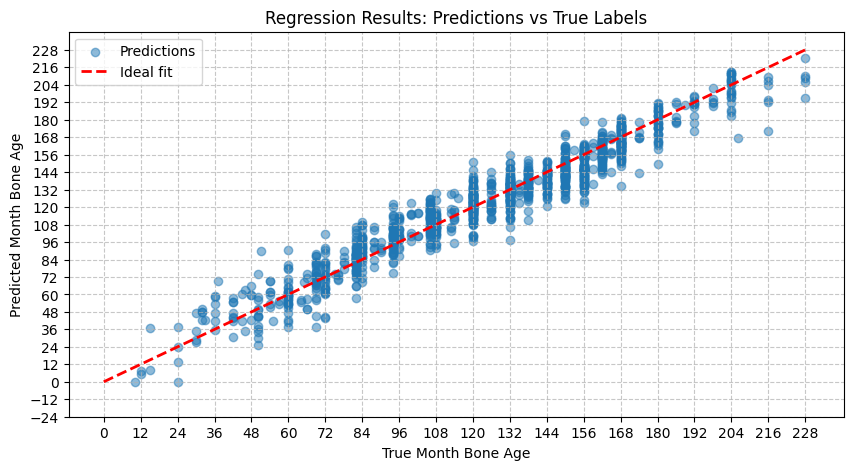

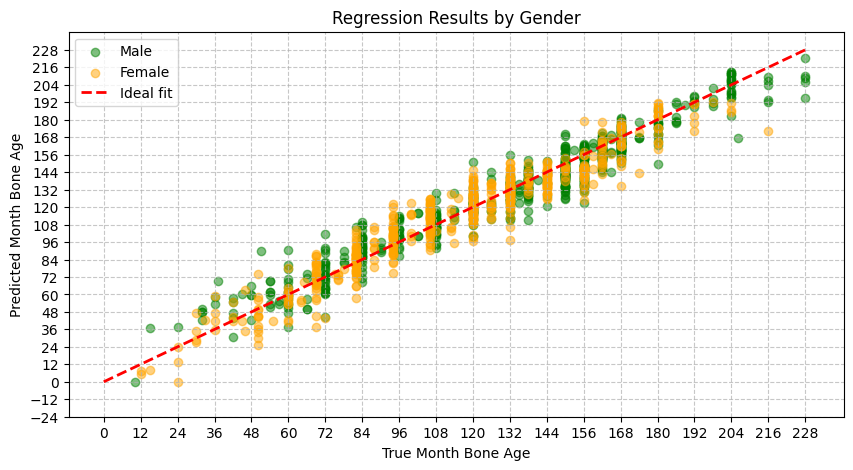

In [ ]:
plot_regression_results(ResNet_gender2_dict_results)

In [ ]:
model = GlobalLocal_base
path = "GL_RESNET.weights.h5"
gender_shape = None
load_saved_weights(model, best_weights_folder, path)

GlobalLocal_base_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:21<00:00,  1.04s/batch]


Overall MAE: 11.119860649108887
Male MAE: 10.293767929077148
Female MAE: 11.18166732788086

Overall Accuracy within 1 year: 62.97%
Male Accuracy within 1 year: 71.39%
Female Accuracy within 1 year: 53.60%


In [ ]:
model = GlobalLocal_gender1
path = "GL_RESNET_g1.weights.h5"
gender_shape = (2,)
load_saved_weights(model, best_weights_folder, path)

GlobalLocal_gender1_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:06<00:00,  1.20batch/s]


Overall MAE: 8.559338569641113
Male MAE: 8.388168334960938
Female MAE: 8.572144508361816

Overall Accuracy within 1 year: 73.51%
Male Accuracy within 1 year: 76.20%
Female Accuracy within 1 year: 70.52%


In [52]:
model = GlobalLocal_gender2
path = "GL_RESNET_g2.weights.h5"
gender_shape = 1
load_saved_weights(model, best_weights_folder, path)

GlobalLocal_gender2_dict_results = evaluate_models(model, test_data, gender_shape)

Test: 100%|██████████| 79/79 [01:03<00:00,  1.25batch/s]


Overall MAE: 8.485677719116211
Male MAE: 8.265727043151855
Female MAE: 8.5021333694458

Overall Accuracy within 1 year: 73.75%
Male Accuracy within 1 year: 76.05%
Female Accuracy within 1 year: 71.19%
